In [36]:
#Import Useful Modules
from pyatmos import download_sw_nrlmsise00, read_sw_nrlmsise00 #atmosphere data
from pyatmos import nrlmsise00
import sympy as sym
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
import time

#Requires ipympl
#%matplotlib widget

In [37]:
# Update space weather data
swfile = download_sw_nrlmsise00() 
swdata = read_sw_nrlmsise00(swfile) 

The Space Weather file 'SW-All.csv' in C:\Users\Brody/src/sw-data/ is already the latest.


In [38]:
M_dict = {
    'He': 4.002602,
    'O': 15.999,
    'N2': 28.014,
    'O2': 31.998,
    'Ar': 39.948,
    'H': 1.00784,
    'N': 14.007,
    'ANM O': 15.999,
}
g_dict = {
    'He': 1.66,
    'O': 1.66,
    'N2': 1.40,
    'O2': 1.40,
    'Ar': 1.66,
    'H': 1.66,
    'N': 1.66,
    'ANM O': 1.66,
}
Av_kg = 6.023e23*1e3 # 1/k mol
R_ideal = 8.314*1e3 #mJ / mol K

In [39]:
#Earth Parameters
r_e = 6.371*1e6 #m
G_e = 3.986*1e14 #m3⋅s−2

In [41]:
t = '2023-11-20 12:00:00' # time(UTC) 
#lat,lon,alt = 25,102,86 # latitude, longitude in [degree], and altitude in [km]

def speed_of_sound(lat, lon, alt, t):
    nrl00 = nrlmsise00(t, (lat, lon, alt), swdata)
    
    t_d = 0
    n_c = 0
    d_c = 0
    for spec in nrl00.nd:
        t_d += nrl00.nd[spec]
        n_c += nrl00.nd[spec]*g_dict[spec]/(g_dict[spec]-1)
        d_c += nrl00.nd[spec]/(g_dict[spec]-1)

    M_net = (nrl00.rho*Av_kg/t_d)
    R_net = R_ideal/M_net
    gamma_net = n_c/d_c
    cs_calc = np.sqrt(gamma_net*R_net*nrl00.T)
    
    return cs_calc, gamma_net, nrl00.rho

In [42]:
#Create symbols to use in equations
#Note: +x is defined as the windward direction
x_s, y_s, z_s = sym.symbols('x y z')
vs = sym.symbols('y z')
R_s, L_s, a_s, M_s = sym.symbols('R L a M')

In [43]:
#----------- SET VEHICLE BODY PARAMETERS ----------
#Radius
R = 0.27 #m
#Length factor
L = 1.8
#Mass
m = 350 #kg
#Body shape
body_shape = 'cone'
    
#----------- ADDITIONAL BODY PARAMETERS -------------
#Exclude edges of the surface from the integration domain to prevent errors
bound_sf = (1-1e-15)

In [44]:
##----------- SET FLIGHT VEHICLE SHAPE EQUATIONS #-----------

if body_shape == 'ellipsoid':
    #----------- SET ELLIPSOID EQUATIONS ----------------
    #Windward surface of the ellipsoid
    s = (-(2*z_s*(L_s**2-R_s**2)*sym.cos(a_s)*sym.sin(a_s))-sym.sqrt((2*(L_s**2-R_s**2)*sym.cos(a_s)*sym.sin(a_s)*z_s)**2-4*(R_s**2*sym.cos(a_s)**2+L_s**2*sym.sin(a_s)**2)*(z_s**2*(R_s**2*sym.sin(a_s)**2+L_s**2*sym.cos(a_s)**2)+L_s**2*(y_s**2-R_s**2))))/(2*(R_s**2*sym.cos(a_s)**2+L_s**2*sym.sin(a_s)**2))
    #Upper surface curve when set equal to zero, symmetric across horizontal axis
    bu_f = (2*(L_s**2-R_s**2)*sym.cos(a_s)*sym.sin(a_s)*z_s)**2-4*(R_s**2*sym.cos(a_s)**2+L_s**2*sym.sin(a_s)**2)*(z_s**2*(R_s**2*sym.sin(a_s)**2+L_s**2*sym.cos(a_s)**2)+L_s**2*(y_s**2-R_s**2))

elif body_shape == 'cone':
    #----------- SET CONE EQUATIONS ----------------
    #Windward surface of the ellipsoid
    s = ((2*R_s**2*(z_s-L_s*sym.sin(a_s))*sym.cos(a_s)*sym.sin(a_s)+2*(z_s-L_s*sym.sin(a_s))*sym.cos(a_s)*sym.sin(a_s))+sym.sqrt((-2*R_s**2*(z_s-L_s*sym.sin(a_s))*sym.cos(a_s)*sym.sin(a_s)-2*(z_s-L_s*sym.sin(a_s))*sym.cos(a_s)*sym.sin(a_s))**2-4*(R_s**2*sym.cos(a_s)**2-sym.sin(a_s)**2)*(R_s**2*(z_s-L_s*sym.sin(a_s))**2*sym.sin(a_s)**2-(z_s-L_s*sym.sin(a_s))**2*sym.cos(a_s)**2-y_s**2)))/(2*(R_s**2*sym.cos(a_s)**2-sym.sin(a_s)**2))
    #Upper surface curve when set equal to zero, symmetric across horizontal axis
    bu_f = sym.cos(a_s)*sym.sqrt(L_s**2*R_s**2-y_s**2)-z_s

In [45]:
#--------- USEFUL CALCULATION QUANTITIES -----------
#Partial derivatives of the surface function
py = sym.diff(s, y_s)
pz = sym.diff(s, z_s)

#Solution for the upper boundary of integration
bu = sym.solve(bu_f, z_s)
bu = bu[len(bu)-1]

#Square of the normal component of the surface, n_x^2
nx2 = 1/(1+py**2+pz**2)

#Cotangent of the surface to the freestream at a point
cot = sym.sqrt((1/nx2)-1)*(-pz/sym.Abs(pz))

#Integrand for calculating coeficient of lift
nx2cot = nx2*cot

In [46]:
#----- FUNCTION FOR GETTING C_d and C_l FROM AOA -------
def coeff_aoa(aoa, area_scaled = True):
    #Convert from degrees to radians
    aoa = aoa*np.pi/180
    
    #------- CREATE FAST FUNCTIONS FOR INTEGRATION ---------
    #Upper edge height from  pitching axis as function of dist along that axis
    #For a given body geometry and angle of attack
    fvbu = bound_sf*bu.subs(L_s,L).subs(R_s,R).subs(a_s,aoa).evalf()
    syms = [sym.parse_expr(item) for item in [str(fvbu)]]
    f_bu = [sym.lambdify(y_s, f) for f in syms]

    #C_d integrand as a function of position
    #For a given body geometry and angle of attack
    fvnx2 = nx2.subs(L_s,L).subs(R_s,R).subs(a_s,aoa).evalf()
    syms = [sym.parse_expr(item) for item in [str(fvnx2)]]
    f_nx2 = [sym.lambdify(vs, f) for f in syms]

    #C_l integrand as a function of position
    #For a given body geometry and angle of attack
    fnx2cot = nx2cot.subs(L_s,L).subs(R_s,R).subs(a_s,aoa).evalf()
    syms = [sym.parse_expr(item) for item in [str(fnx2cot)]]
    f_nx2cot = [sym.lambdify(vs, f) for f in syms]
    
    #------- INTEGRATIONS ---------
    #Projected cross sectional area (half)
    A = integrate.dblquad(lambda z, y: 1, 0, R, lambda y: -[f(y) for f in f_bu][0], lambda y: [f(y) for f in f_bu][0])[0]
    
    #C_d (divided by maximum C_p)
    C_d_Cpm_i = integrate.dblquad(lambda z, y: [f(y, z) for f in f_nx2][0] , 0, R, lambda y: -[f(y) for f in f_bu][0], lambda y: [f(y) for f in f_bu][0])[0]

    #C_l (divided by maximum C_p)
    C_l_Cpm_i = integrate.dblquad(lambda z, y: [f(y, z) for f in f_nx2cot][0] , 0, R, lambda y: -[f(y) for f in f_bu][0], lambda y: [f(y) for f in f_bu][0])[0]
    
    if not area_scaled:
        #Return purely the aero coefficients
        C_d_Cpm_i = C_d_Cpm_i/A
        C_l_Cpm_i = C_l_Cpm_i/A

        #Otherwise return aero coefficients * A/2 for easier computation
        
    return C_d_Cpm_i, C_l_Cpm_i

In [47]:
#----- FUNCTION FOR GETTING INSTANTANEOUS AERO PARAMETERS -------
def instant_coeff(C_d_Cpm, C_l_Cpm, M, gamma):
    #Instantaneous coeffcient of max pressure
    C_p_max = (2/(gamma*M**2))*((((gamma+1)**2*M**2)/(4*gamma*M**2-2*gamma+2))**(gamma/(gamma-1))*((1-gamma+2*gamma*M**2)/(gamma+1))-1)

    #Instantaneous coeffcient of drag
    C_d = C_d_Cpm*C_p_max

    #Instantaneous coeffcient of lift
    C_l = C_l_Cpm*C_p_max
    
    return C_p_max, C_d, C_l

In [48]:
#Calculate ceofficients for an angle of attack
C_d_Cpm, C_l_Cpm = coeff_aoa(-8, area_scaled = True)

In [49]:
#------- FLIGHT INSTANTANEOUS CONDITION --------
v_mag = 7852.68 #m/s
z_alt = 100000 #m

cs_calc, gamma_calc, rho_calc = speed_of_sound(25, 102, z_alt/1e3, t)

M_v = v_mag/cs_calc
gamma_v = gamma_calc

#Instantaneous aerodynamic coefficients
C_p_max, C_d, C_l = instant_coeff(C_d_Cpm, C_l_Cpm , M=M_v, gamma=gamma_v)

C:\Users\Brody\anaconda3\envs\ae483\lib\site-packages\pyatmos\msise\spaceweather.py:107: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ap_c = aph_tmp_b0[i]


In [50]:
#Display aerodynamic coefficients for verification
print('C_p_max   : '+str(C_p_max))
print('A * C_d/2 : '+str(C_d))
print('A * C_l/2 : '+str(C_l))

C_p_max   : 1.8359368565856238
A * C_d/2 : 0.04598796849872425
A * C_l/2 : -0.08359738605133538


In [51]:
D_f = C_d*rho_calc*v_mag*v_mag
D_acc = D_f/m

L_f = C_l*rho_calc*v_mag*v_mag
L_acc = L_f/m

print('Drag acc : '+str(D_acc))
print('Lift acc : '+str(L_acc))
print('Total acc: '+str(np.sqrt(L_acc*L_acc+D_acc*D_acc)))

Drag acc : 0.005681179464424132
Lift acc : -0.010327304475899125
Total acc: 0.011786815424232305


In [52]:
def basic_step(r_vec, v_vec, dt=1.0, bank = 0.0):
    #------- FLIGHT INSTANTANEOUS CONDITION --------
    v_mag = np.linalg.norm(v_vec)
    z_alt = np.linalg.norm(r_vec)-r_e
    d_vec = r_vec/np.linalg.norm(r_vec)
    d_vel = (v_vec/v_mag)
    bank = bank*(np.pi/180)

    #Global Position Coordinates
    lat_int = 90-np.arccos(d_vec[2])*180/np.pi
    long_int = np.arccos(d_vec[0]/np.sin((90-lat_int)*np.pi/180))*180/np.pi

    cs_calc, gamma_calc, rho_calc = speed_of_sound(lat_int, long_int, z_alt/1e3, t)

    M_v = v_mag/cs_calc
    gamma_v = gamma_calc
    
    if M_v < 5 or z_alt<0:
        return r_vec, v_vec, False

    #Instantaneous aerodynamic coefficients
    C_p_max, C_d, C_l = instant_coeff(C_d_Cpm, C_l_Cpm , M=M_v, gamma=gamma_v)

    D_f = C_d*rho_calc*v_mag*v_mag
    D_acc = D_f/m

    L_f = C_l*rho_calc*v_mag*v_mag
    L_acc = L_f/m

    W_acc = G_e/(z_alt+r_e)**2

    r_vec += dt * v_vec
    v_vec += -dt * W_acc * d_vec
    v_vec += -dt * D_acc * d_vel
    
    #Lift Caclulations
        #Zero bank lift direction
    d_l0b = np.cross(d_vel, np.cross(d_vel, d_vec))
    d_lift = np.cos(bank)*d_l0b + np.sin(bank) * np.cross(d_vel, d_l0b)
    v_vec += dt * L_acc * d_lift
    
    acc_g = np.sqrt(D_acc**2 + (L_acc)**2)
        
    #path_alt.append(z_alt*1e-3)
    #path_vel.append(v_mag*1e-3)
    #path_mach.append(M_v)
    path_long.append(long_int)
    path_lat.append(lat_int)
    #path_acc.append(acc_g)
    
    return r_vec, v_vec, True

In [53]:
#------- INITIALIZE FLIGHT CONDITIONS --------
lat_i = 0
long_i = 0
z_i = 100000
entry_rot = 0
v_entry_mag = 7910.0

dt_mult = 1.

In [29]:
end_bank_10 = []
end_lat_10 = []
end_long_10 = []

for j in np.linspace(0,180, 37):
    C_d_Cpm, C_l_Cpm = coeff_aoa(3, area_scaled = True)
    
    z_vec = np.array([z_i*np.sin((90-lat_i)*np.pi/180)*np.cos(long_i*np.pi/180), z_i*np.sin((90-lat_i)*np.pi/180)*np.sin(long_i*np.pi/180), z_i*np.cos((90-lat_i)*np.pi/180)])
    r_vec = (np.linalg.norm(z_vec)+r_e)*z_vec/np.linalg.norm(z_vec)
    v_vec = np.array([0.0, v_entry_mag, 0.0])
    
    path_lat = []
    path_long = []
    
    for i in range(int(500*dt_mult)):
        r_vec, v_vec, hyper = basic_step(r_vec, v_vec, dt=1./dt_mult, bank = j)
        if not hyper:
            break
    print(j)
    end_bank_10.append(j)
    end_lat_10.append(path_lat[-1])
    end_long_10.append(path_long[-1])

0.0
5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
65.0
70.0
75.0
80.0
85.0
90.0
95.0
100.0
105.0
110.0
115.0
120.0
125.0
130.0
135.0
140.0
145.0
150.0
155.0
160.0
165.0
170.0
175.0
180.0


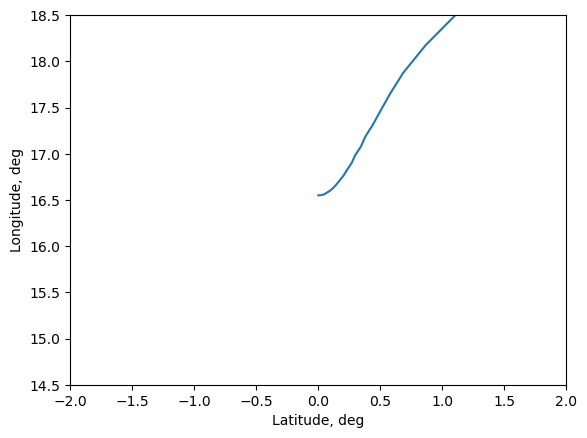

In [30]:
plt.clf()
plt.plot(end_lat_10, end_long_10)
plt.xlabel('Latitude, deg')
plt.ylabel('Longitude, deg')
plt.ylim([14.5, 18.5])
plt.xlim([-2.0, 2.0])
plt.show()

In [31]:
end_bank_26 = []
end_lat_26 = []
end_long_26 = []

for j in np.linspace(0,180, 37):
    C_d_Cpm, C_l_Cpm = coeff_aoa(8, area_scaled = True)
    
    z_vec = np.array([z_i*np.sin((90-lat_i)*np.pi/180)*np.cos(long_i*np.pi/180), z_i*np.sin((90-lat_i)*np.pi/180)*np.sin(long_i*np.pi/180), z_i*np.cos((90-lat_i)*np.pi/180)])
    r_vec = (np.linalg.norm(z_vec)+r_e)*z_vec/np.linalg.norm(z_vec)
    v_vec = np.array([0.0, 7010.0, 0.0])
    
    path_lat = []
    path_long = []
    
    for i in range(int(500*dt_mult)):
        r_vec, v_vec, hyper = basic_step(r_vec, v_vec, dt=1./dt_mult, bank = j)
        if not hyper:
            break
    print(j)
    end_bank_26.append(j)
    end_lat_26.append(path_lat[-1])
    end_long_26.append(path_long[-1])

0.0
5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
65.0
70.0
75.0
80.0
85.0
90.0
95.0
100.0
105.0
110.0
115.0
120.0
125.0
130.0
135.0
140.0
145.0
150.0
155.0
160.0
165.0
170.0
175.0
180.0


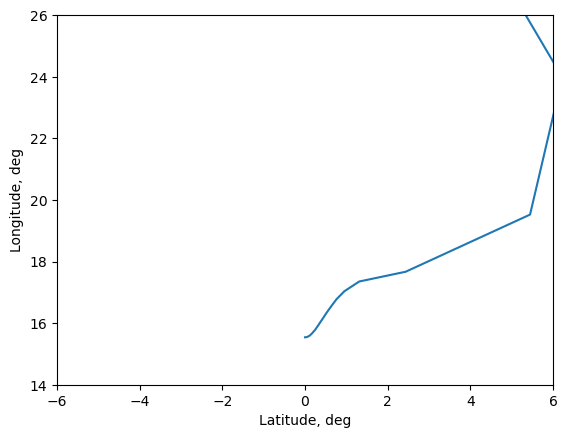

In [32]:
plt.clf()
plt.plot(end_lat_26, end_long_26)
plt.xlabel('Latitude, deg')
plt.ylabel('Longitude, deg')
plt.ylim([14, 26])
plt.xlim([-6.0, 6.0])
plt.show()

In [34]:
end_bank_1 = []
end_lat_1 = []
end_long_1 = []

for j in np.linspace(0,180, 19):
    C_d_Cpm, C_l_Cpm = coeff_aoa(1, area_scaled = True)
    
    z_vec = np.array([z_i*np.sin((90-lat_i)*np.pi/180)*np.cos(long_i*np.pi/180), z_i*np.sin((90-lat_i)*np.pi/180)*np.sin(long_i*np.pi/180), z_i*np.cos((90-lat_i)*np.pi/180)])
    r_vec = (np.linalg.norm(z_vec)+r_e)*z_vec/np.linalg.norm(z_vec)
    v_vec = np.array([0.0, 7010.0, 0.0])
    
    path_lat = []
    path_long = []
    
    for i in range(int(500*dt_mult)):
        r_vec, v_vec, hyper = basic_step(r_vec, v_vec, dt=2./dt_mult, bank = j)
        if not hyper:
            break
    print(j)
    end_bank_1.append(j)
    end_lat_1.append(path_lat[-1])
    end_long_1.append(path_long[-1])

C:\Users\Brody\anaconda3\envs\ae483\lib\site-packages\scipy\integrate\_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


0.0
10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0
110.0
120.0
130.0
140.0
150.0
160.0
170.0
180.0


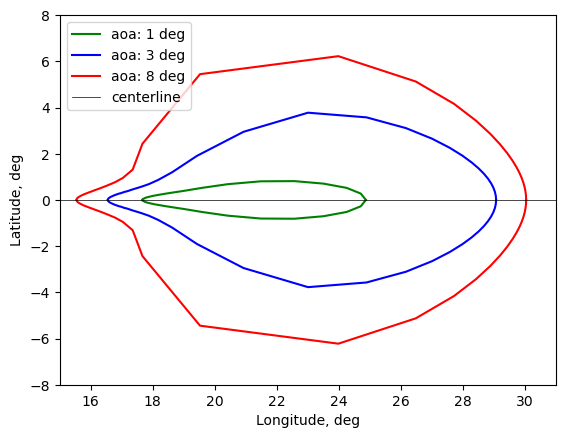

In [35]:
plt.clf()
plt.plot(end_long_1, end_lat_1, label="aoa: 1 deg", color='green')
plt.plot(end_long_10, end_lat_10, label="aoa: 3 deg", color='blue')
plt.plot(end_long_26, end_lat_26, label="aoa: 8 deg", color='red')
plt.plot(end_long_1, -1*np.array(end_lat_1),color='green')
plt.plot(end_long_10, -1*np.array(end_lat_10),color='blue')
plt.plot(end_long_26, -1*np.array(end_lat_26),color='red')
plt.plot([0,90], [0,0], label='centerline', color='black', linewidth=0.5)
plt.ylabel('Latitude, deg')
plt.xlabel('Longitude, deg')
plt.xlim([15, 31])
plt.ylim([-8.0, 8.0])
plt.legend()
plt.show()